Key Features:

Synthetic Data Generation: Creates 150 signals representing:

Wave packets (localized oscillations)
Phase space holes (amplitude dips)
Double layers (bipolar pulses)


Feature Extraction (11 features):

Time domain: amplitude, energy, mean, std, skewness, kurtosis
Frequency domain: dominant frequency, spectral centroid, bandwidth
Structural: number of peaks, zero crossings


DBSCAN Parameters:

eps=0.5: Maximum distance between points in a cluster
min_samples=5: Minimum points to form a dense region
Outputs cluster labels (-1 for noise points)


Visualization: 4 plots showing:

Clustering results in PCA space
Example signals from each cluster
True labels (validation)
Feature importance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import signal as sp_signal
from scipy.fft import fft, fftfreq

In [2]:

# Generate synthetic signal data with different phenomena
np.random.seed(42)
n_samples = 150
t = np.linspace(0, 10, 1000)

def generate_wave_packet(t, f0, duration):
    """Generate a wave packet (localized oscillation)"""
    envelope = np.exp(-((t - 5)**2) / duration)
    wave = envelope * np.sin(2 * np.pi * f0 * t)
    return wave + np.random.normal(0, 0.05, len(t))

def generate_phase_space_hole(t, depth):
    """Generate a phase space hole (dip in amplitude)"""
    hole = 1 - depth * np.exp(-((t - 5)**2) / 0.5)
    wave = hole * np.sin(2 * np.pi * 3 * t)
    return wave + np.random.normal(0, 0.05, len(t))

def generate_double_layer(t, amplitude):
    """Generate a double layer structure (bipolar pulse)"""
    pulse1 = amplitude * np.exp(-((t - 4)**2) / 0.3)
    pulse2 = -amplitude * np.exp(-((t - 6)**2) / 0.3)
    return pulse1 + pulse2 + np.random.normal(0, 0.05, len(t))

# Generate dataset
signals = []
labels_true = []  # For validation only, not used in clustering

# Wave packets (50 samples)
for i in range(50):
    f0 = np.random.uniform(2, 5)
    duration = np.random.uniform(0.5, 2)
    signals.append(generate_wave_packet(t, f0, duration))
    labels_true.append(0)

# Phase space holes (50 samples)
for i in range(50):
    depth = np.random.uniform(0.3, 0.8)
    signals.append(generate_phase_space_hole(t, depth))
    labels_true.append(1)

# Double layers (50 samples)
for i in range(50):
    amplitude = np.random.uniform(0.5, 1.5)
    signals.append(generate_double_layer(t, amplitude))
    labels_true.append(2)

signals = np.array(signals)
labels_true = np.array(labels_true)


In [3]:

# Feature extraction
def extract_features(signal_data):
    """Extract relevant features from signals"""
    features = []
    
    for sig in signal_data:
        # Time domain features
        amplitude = np.max(np.abs(sig))
        energy = np.sum(sig**2)
        mean_val = np.mean(sig)
        std_val = np.std(sig)
        skewness = np.mean(((sig - mean_val) / std_val)**3)
        kurtosis = np.mean(((sig - mean_val) / std_val)**4)
        
        # Frequency domain features
        fft_vals = np.abs(fft(sig))
        fft_vals = fft_vals[:len(fft_vals)//2]
        freqs = fftfreq(len(sig), t[1] - t[0])[:len(fft_vals)]
        
        dominant_freq = freqs[np.argmax(fft_vals)]
        spectral_centroid = np.sum(freqs * fft_vals) / np.sum(fft_vals)
        spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid)**2) * fft_vals) / np.sum(fft_vals))
        
        # Peak detection
        peaks, _ = sp_signal.find_peaks(np.abs(sig), height=0.1)
        num_peaks = len(peaks)
        
        # Zero crossings
        zero_crossings = np.sum(np.diff(np.sign(sig)) != 0)
        
        features.append([
            amplitude, energy, mean_val, std_val, skewness, kurtosis,
            dominant_freq, spectral_centroid, spectral_bandwidth,
            num_peaks, zero_crossings
        ])
    
    return np.array(features)

print("Extracting features...")
features = extract_features(signals)



Extracting features...


In [4]:
# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [5]:
# Apply DBSCAN
print("\nApplying DBSCAN clustering...")
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
clusters = dbscan.fit_predict(features_scaled)


Applying DBSCAN clustering...


In [6]:
# Results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"\nClustering Results:")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Cluster distribution: {np.bincount(clusters[clusters >= 0])}")


Clustering Results:
Number of clusters found: 3
Number of noise points: 129
Cluster distribution: [10  4  7]


In [7]:
# Dimensionality reduction for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)


Plot saved as 'dbscan_clustering_results.png'


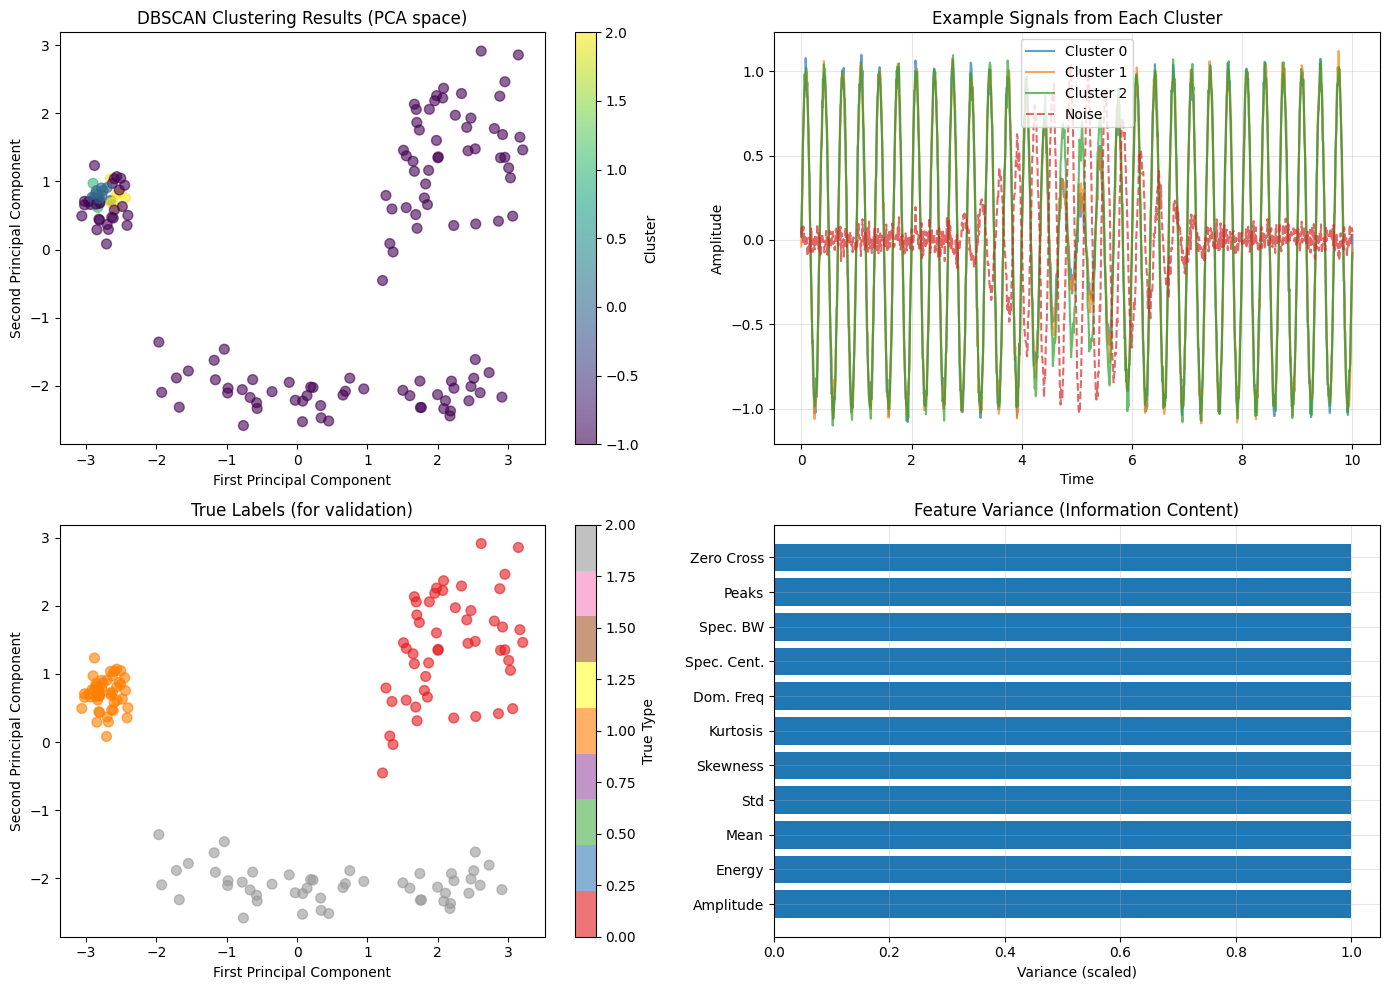


HYPERPARAMETER TUNING TIPS:
1. eps (epsilon): Controls neighborhood size
   - Too small: Many noise points, too many clusters
   - Too large: Everything in one cluster
   - Try range: [0.3, 0.5, 0.7, 1.0]

2. min_samples: Minimum points to form cluster
   - Higher value: More conservative, fewer clusters
   - Lower value: More clusters, less noise
   - Try range: [3, 5, 10, 15]

3. metric: Distance measure
   - 'euclidean': Standard choice
   - 'cosine': Good for directional similarity
   - 'manhattan': Less sensitive to outliers


In [8]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: PCA visualization with DBSCAN clusters
ax1 = axes[0, 0]
scatter = ax1.scatter(features_pca[:, 0], features_pca[:, 1], 
                      c=clusters, cmap='viridis', s=50, alpha=0.6)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_title('DBSCAN Clustering Results (PCA space)')
plt.colorbar(scatter, ax=ax1, label='Cluster')

# Plot 2: Example signals from each cluster
ax2 = axes[0, 1]
for cluster_id in range(n_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    if len(cluster_indices) > 0:
        example_idx = cluster_indices[0]
        ax2.plot(t, signals[example_idx], label=f'Cluster {cluster_id}', alpha=0.7)
if n_noise > 0:
    noise_idx = np.where(clusters == -1)[0][0]
    ax2.plot(t, signals[noise_idx], label='Noise', alpha=0.7, linestyle='--')
ax2.set_xlabel('Time')
ax2.set_ylabel('Amplitude')
ax2.set_title('Example Signals from Each Cluster')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: True labels (for validation)
ax3 = axes[1, 0]
scatter_true = ax3.scatter(features_pca[:, 0], features_pca[:, 1], 
                           c=labels_true, cmap='Set1', s=50, alpha=0.6)
ax3.set_xlabel('First Principal Component')
ax3.set_ylabel('Second Principal Component')
ax3.set_title('True Labels (for validation)')
plt.colorbar(scatter_true, ax=ax3, label='True Type')

# Plot 4: Feature importance (variance explained)
ax4 = axes[1, 1]
feature_names = ['Amplitude', 'Energy', 'Mean', 'Std', 'Skewness', 'Kurtosis',
                 'Dom. Freq', 'Spec. Cent.', 'Spec. BW', 'Peaks', 'Zero Cross']
feature_variance = np.var(features_scaled, axis=0)
ax4.barh(feature_names, feature_variance)
ax4.set_xlabel('Variance (scaled)')
ax4.set_title('Feature Variance (Information Content)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dbscan_clustering_results.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as 'dbscan_clustering_results.png'")
plt.show()

# Hyperparameter tuning suggestions
print("\n" + "="*50)
print("HYPERPARAMETER TUNING TIPS:")
print("="*50)
print("1. eps (epsilon): Controls neighborhood size")
print("   - Too small: Many noise points, too many clusters")
print("   - Too large: Everything in one cluster")
print("   - Try range: [0.3, 0.5, 0.7, 1.0]")
print("\n2. min_samples: Minimum points to form cluster")
print("   - Higher value: More conservative, fewer clusters")
print("   - Lower value: More clusters, less noise")
print("   - Try range: [3, 5, 10, 15]")
print("\n3. metric: Distance measure")
print("   - 'euclidean': Standard choice")
print("   - 'cosine': Good for directional similarity")
print("   - 'manhattan': Less sensitive to outliers")